# Transformada Cuántica de Fourier

Implemente y analice en el simulador Quirk y en el Qiskit los siguientes ejercicios:

In [756]:
import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Ejercicio 1

Implementar la a QFT y la QFT-1 de 4 qubits.

### QFT

![QFT4](../images//qft4.png)

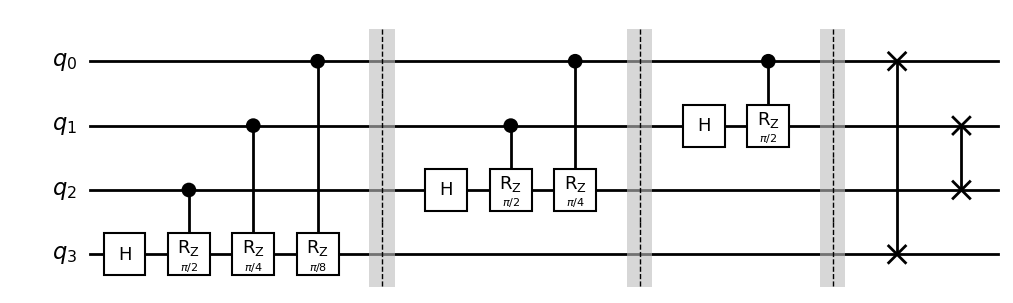

In [757]:
def qft(number_of_qubits):
    
    quantum_circuit = QuantumCircuit(number_of_qubits, name="QTF")
    
    accesible_qubits = number_of_qubits - 1
        
    # Por cada qubit, se aplica una rotación extra.
    # Al primer qubit, solo se le aplica Hadamard.
    # Al segundo, una rotación de pi/2 y Hadamard.
    # Al tercero, una rotación de pi/4, una rotación de pi/2 y Hadamard.
    for i in range(accesible_qubits, 0, -1):
        
        # Se aplica Hadamard previo a las rotaciones.
        quantum_circuit.h(i)
        
        for j in range(i):
            quantum_circuit.crz(math.pi/(2 ** (j+1)), i - j - 1, i)
        
        # Se aplica una barrera para evitar el autoordenamiento de Qiskit.
        quantum_circuit.barrier()
        
    # Swap entre el qubit 0 y el n - 1.
    # Swap entre el qubit 1 y el n - 2.
    # Y así hasta llegar al centro.
    for i in range(int(number_of_qubits/2)):
        quantum_circuit.swap(i, accesible_qubits - i)
        
    return quantum_circuit
        
qc = qft(4)
qc.draw(output='mpl', style='bw')

### IQTF

![IQFT4](../images/iqft4.png)

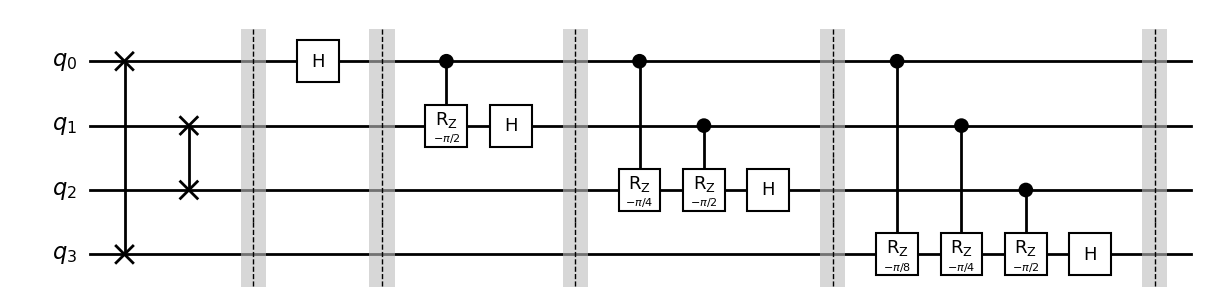

In [758]:
def iqtf(number_of_qubits):
    
    quantum_circuit = QuantumCircuit(number_of_qubits, name="IQTF")
    
    accesible_qubits = number_of_qubits - 1
    
    # Swap entre el qubit 0 y el n - 1.
    # Swap entre el qubit 1 y el n - 2.
    # Y así hasta llegar al centro.
    
    # Los swaps pueden ahorrarse si se invierte el orden de los qubits resultados.
    for i in range(int(number_of_qubits/2)):
        quantum_circuit.swap(i, accesible_qubits - i)
        
    quantum_circuit.barrier()
        
    # Por cada qubit, se aplica una rotación extra.
    # Al primer qubit, solo se le aplica Hadamard.
    # Al segundo, una rotación de pi/2 y Hadamard.
    # Al tercero, una rotación de pi/4, una rotación de pi/2 y Hadamard.
    for i in range(number_of_qubits):
        
        for j in range(i, 0, -1):
            # crz(angulo, control, objetivo)
            quantum_circuit.crz(-math.pi/(2 ** j), i - j, i)
        
        # Se aplica un Hadamard luego de las rotaciones.
        quantum_circuit.h(i)
        
        # Se aplica una barrera para evitar el autoordenamiento de Qiskit.
        quantum_circuit.barrier()
        
    return quantum_circuit
        
qc = iqtf(4)
qc.draw(output='mpl', style='bw')

## Ejercicio 2

El ejemplo de suma de 5 qubits (en estados básicos) usando el dominio de Fourier y QFT-1 (ejemplo de teoría)

![Suma de 5 qubits (en estados básicos) usando el dominio de Fourier y QFT-1](../images/suma5qubitsQFT.png)

In [759]:
def calcular_qubits_resultantes_de_suma(qubits_en_cada_operando, operandos):
    
    """
    Cada dos operandos, puede haber un acarreo.
    - 1 operando -> Qubits en el operando.
    - 2 operandos -> Qubits en los operandos + 1. (Posibilidad de acarreo).
    - 3 operandos -> Qubits en los operandos + 1. (Posibilidad de acarreo).
    - 4 operandos -> Qubits en los operandos + 2. (Posibilidad de acarreo y acarreo en el acarreo).
    - 5 operandos -> Qubits en los operandos + 2.
    - 6 operandos -> Qubits en los operandos + 2.
    - 7 operandos -> Qubits en los operandos + 2-
    - 8 operandos -> Qubits en los operandos + 3.
    - ...
    - n operands -> Qubits in each operand + floor(log2(operands))
    """
    
    return qubits_en_cada_operando + math.floor(math.log2(operandos))

calcular_qubits_resultantes_de_suma(1, 8)

4

Se considera al qubit menos significativo al de arriba, por lo que es a quien se le aplica la mayor rotación.

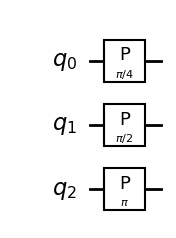

In [760]:
def plus1(qubits):
    
    accesible_qubits = qubits - 1
    quantum_circuit = QuantumCircuit(qubits, name="TSZ")
    
    for qubit in range(qubits):
        # Cambio de fase.
        quantum_circuit.p(math.pi/(2 ** qubit), accesible_qubits - qubit) # Si se considera a q0 como el MSB.
        #quantum_circuit.p(math.pi/(2 ** qubit), qubit) # Considerando a q0 como el LSB. Permite no utilizar swaps en la IQFT.
        
    return quantum_circuit

plus1(3).draw(output='mpl', style='bw')

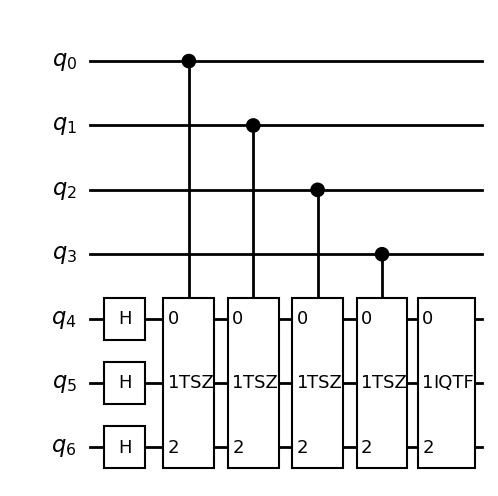

In [761]:
def calcular_suma_monoqubit(operands):
    
    result_qubits = calcular_qubits_resultantes_de_suma(1, operands)
    
    quantum_circuit = QuantumCircuit(operands + result_qubits, name="Adder")
    
    # Se entra en el dominio de Fourier.
    #quantum_circuit.append(qft(operands), list(range(operands, operands + result_qubits)))
    
    for i in range(operands, operands + result_qubits, 1):
        quantum_circuit.h(i)
        
    for i in range(operands):
        # Creación de la columna de fases (T, S, Z...).
        gate_columna = plus1(result_qubits)
        
        # La columna es controlada solo por un qubit.
        controlled_gate = gate_columna.to_gate().control(1)
        
        # Se definen los "cables": [Control, Objetivo1, Objetivo2, Objetivo3...].
        # Control: es el qubit 'i' (input).
        # Objetivos: son los qubits del acumulador (del 5 al 7).
        qubit_control = [i]
        qubits_objetivo = list(range(operands, operands + result_qubits))
        
        wiring = qubit_control + qubits_objetivo
        
        # Añadido del cableado al circuito.
        quantum_circuit.append(controlled_gate, wiring)
        
    # Se añade la transformada cuántica de Fourier inversa para decodificar el resultado.
    quantum_circuit.append(iqtf(result_qubits), list(range(operands, operands + result_qubits)))
        
    
    return quantum_circuit

number_of_qubits = 4
result_qubits = calcular_qubits_resultantes_de_suma(1, number_of_qubits)
qc = calcular_suma_monoqubit(number_of_qubits)
qc.draw(output='mpl', style='bw')

Añadido de las mediciones:

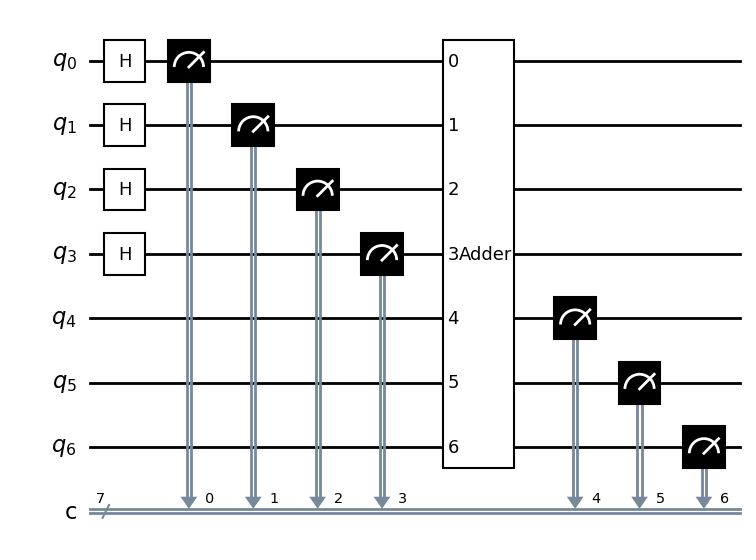

In [762]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits + result_qubits, number_of_qubits + result_qubits)

# Superposición de los operandos.
measured_quantum_circuit.h(list(range(number_of_qubits)))

# Medición de los valores de los operandos.
measured_quantum_circuit.measure(list(range(number_of_qubits)), list(range(number_of_qubits)))

measured_quantum_circuit.append(qc, list(range(number_of_qubits + result_qubits)))

for i in range(number_of_qubits, number_of_qubits + result_qubits, 1):
    measured_quantum_circuit.measure(i, i)

measured_quantum_circuit.draw(output='mpl', style='bw')

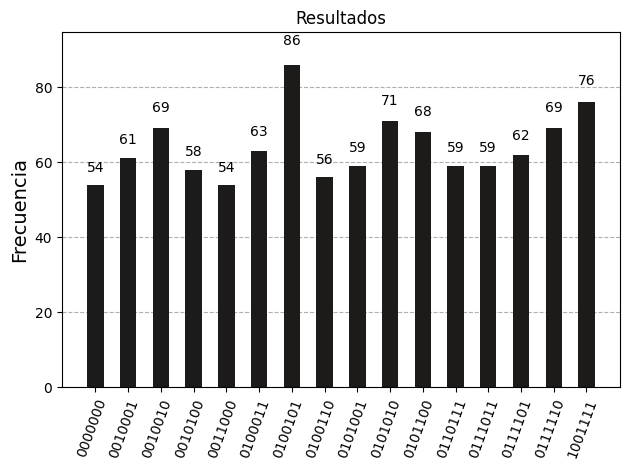

In [763]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

histogram = plot_histogram(counts, title="Resultados", color="#1D1A1A")
histogram.axes[0].set_ylabel("Frecuencia")

histogram

In [764]:
# Definición de anchos de columna para consistencia.
W_QUBITS = 3  # Ancho para A, B, Cin, S y Cout.
W_COUNT = 15 # Ancho para Frecuencia.
W_CORRECT = 10 # Ancho de la correctitud del resultado.
TOTAL_WIDTH = W_QUBITS * 5 + W_COUNT + W_CORRECT + 22 # 8 barras y 14 espacios adicionales.

# Separador
def print_separator(width):
    print(f"|{'-' * (width - 2)}|") # -2 por las barras.

# Título
print_separator(TOTAL_WIDTH)
print(f"|{'Tabla de Verdad - Full-Adder':^{TOTAL_WIDTH - 2}}|") # -2 por las barras.
print_separator(TOTAL_WIDTH)

# Encabezados
print(f"| {'Q0':^{W_QUBITS}} | {'Q1':^{W_QUBITS}} | {'Q2':^{W_QUBITS}} | {'Q3':^{W_QUBITS}} | {'S0':^{W_QUBITS}} | {'S1':^{W_QUBITS}} | {'C':^{W_QUBITS}} | {'Frecuencia':^{W_COUNT}} | {'¿Correcto?':^{W_CORRECT}} |")
print_separator(TOTAL_WIDTH)

for bitstring, count in counts.items():

    # Correspondencia de la salida.
    # El bit menos significativo aparece
    # último en el bitstring.
    q0 = int(bitstring[6])
    q1 = int(bitstring[5])
    q2 = int(bitstring[4])
    q3 = int(bitstring[3])
    s0 = int(bitstring[2])
    s1 = int(bitstring[1])
    carry = int(bitstring[0])
    
    # En Python,
    # & -> And (. o ^).
    # | -> Or (v).
    # ^ -> Xor.
    
    # Los resultados correcto son S = A^B^Cin y Cout = (A^B)Cin v (A.B).
    # Se calcula el resultado esperado para un FA funcional.
    expected_sum = q0 ^ q1 ^ q2 ^ q3
    #expected_cout = (a & b) | (cin & (a ^ b))

    # Comprobación de la lógica del FA:
    is_correct = "NO"
    #if s == expected_sum and cout == expected_cout:
    #    is_correct = "SÍ"

    print(f"| {q0:^{W_QUBITS}} | {q1:^{W_QUBITS}} | {q2:^{W_QUBITS}} | {q3:^{W_QUBITS}} | {s0:^{W_QUBITS}} | {s1:^{W_QUBITS}} | {carry:^{W_QUBITS}} | {count:^{W_COUNT}} | {is_correct:^{W_CORRECT}} |")

# Impresión de la tabla.
print_separator(TOTAL_WIDTH)

|------------------------------------------------------------|
|                Tabla de Verdad - Full-Adder                |
|------------------------------------------------------------|
| Q0  | Q1  | Q2  | Q3  | S0  | S1  |  C  |   Frecuencia    | ¿Correcto? |
|------------------------------------------------------------|
|  0  |  0  |  1  |  0  |  1  |  0  |  0  |       58        |     NO     |
|  1  |  1  |  0  |  1  |  1  |  1  |  0  |       59        |     NO     |
|  0  |  0  |  1  |  1  |  0  |  1  |  0  |       68        |     NO     |
|  0  |  1  |  0  |  1  |  0  |  1  |  0  |       71        |     NO     |
|  0  |  0  |  0  |  0  |  0  |  0  |  0  |       54        |     NO     |
|  0  |  1  |  1  |  0  |  0  |  1  |  0  |       56        |     NO     |
|  1  |  0  |  0  |  1  |  0  |  1  |  0  |       59        |     NO     |
|  0  |  1  |  1  |  1  |  1  |  1  |  0  |       69        |     NO     |
|  0  |  1  |  0  |  0  |  1  |  0  |  0  |       69        |     NO     

In [765]:
def imprimir_tabla_generalizada(counts, n_inputs, n_outputs):
    """
    Imprime una tabla de verdad dinámica verificando si la suma es correcta.
    Asume que el bitstring de Qiskit viene en orden: MSB ... LSB
    Donde los Inputs están en los bits bajos (derecha) y el Resultado en los altos (izquierda).
    """
    
    # 1. Configuración de Anchos
    W_QUBIT = 4   # Ancho para cada columna de bit (Q0, S0, etc)
    W_FREQ = 12   # Ancho para la frecuencia
    W_CHECK = 10  # Ancho para el estado Correcto/Incorrecto
    
    # Generamos las etiquetas de las columnas dinámicamente
    # Entradas: Q0, Q1, ...
    headers_inputs = [f"Q{i}" for i in range(n_inputs)]
    # Salidas: S0, S1, ... (Bit de acarreo sería el S más alto)
    headers_outputs = [f"S{i}" for i in range(n_outputs)]
    
    # Calculamos el ancho total
    # (Ancho * cantidad de columnas) + (3 chars por separador '| x ')
    total_columns = n_inputs + n_outputs
    TOTAL_WIDTH = (total_columns * (W_QUBIT + 3)) + W_FREQ + W_CHECK + 7

    # Funciones auxiliares de formato
    def print_line():
        print(f"|{'-' * (TOTAL_WIDTH - 2)}|")

    # 2. Imprimir Encabezado
    print_line()
    title = f"Tabla de Verdad Generalizada ({n_inputs} Inputs -> {n_outputs} Outputs)"
    print(f"|{title:^{TOTAL_WIDTH - 2}}|")
    print_line()

    # Construcción de la fila de títulos
    header_str = "|"
    # Imprimimos Inputs
    for h in headers_inputs:
        header_str += f" {h:^{W_QUBIT}} |"
    # Imprimimos Outputs (Separador visual)
    header_str += "|" # Doble barra para separar input de output
    for h in headers_outputs:
        header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += f" {'Freq':^{W_FREQ}} | {'¿OK?':^{W_CHECK}} |"
    
    print(header_str)
    print_line()

    # 3. Procesar Datos
    # Ordenamos por bitstring para que la tabla se vea ordenada (000, 001...)
    for bitstring, count in sorted(counts.items()):
        
        # Limpiamos el bitstring (por si Qiskit pone espacios) y quitamos '0b' si existe
        clean_bits = bitstring.replace(" ", "")
        
        # --- PARSEO DINÁMICO ---
        # En Qiskit, el string se lee de Derecha a Izquierda para índices 0, 1, 2...
        # String: "... S1 S0 Q1 Q0"
        
        # 1. Extraer Inputs (Los n_inputs de la derecha)
        # Tomamos los últimos n chars e invertimos para tener [q0, q1, q2...]
        input_chars = clean_bits[-n_inputs:]
        input_bits = [int(b) for b in reversed(input_chars)]
        
        # 2. Extraer Outputs (Los siguientes n_outputs hacia la izquierda)
        # Tomamos el slice correspondiente
        output_chars = clean_bits[-(n_inputs + n_outputs) : -n_inputs]
        output_bits = [int(b) for b in reversed(output_chars)] # [s0, s1, s2...]

        # --- LÓGICA DE VALIDACIÓN ---
        # 1. Valor Esperado: Suma de los inputs (Population Count)
        # Ej: Si inputs son 1, 0, 1 -> Esperado = 2
        valor_esperado = sum(input_bits)
        
        # 2. Valor Real: Convertir binario de salida a decimal
        # output_chars ya viene con el MSB a la izquierda, así que int(str, 2) funciona directo
        valor_real = int(output_chars, 2)
        
        es_correcto = "SÍ" if valor_esperado == valor_real else "NO"
        
        # --- IMPRESIÓN DE FILA ---
        row_str = "|"
        
        # Inputs
        for bit in input_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += "|" # Separador doble
        
        # Outputs
        for bit in output_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += f" {count:^{W_FREQ}} | {es_correcto:^{W_CHECK}} |"
        
        print(row_str)

    print_line()

# --- EJEMPLO DE USO ---
# Suponiendo que 'counts' es tu resultado de Qiskit
# Inputs = 2 (q0, q1)
# Resultados = 3 (q2, q3, q4)
imprimir_tabla_generalizada(counts, n_inputs=number_of_qubits, n_outputs=result_qubits)

|----------------------------------------------------------------------------|
|            Tabla de Verdad Generalizada (4 Inputs -> 3 Outputs)            |
|----------------------------------------------------------------------------|
|  Q0  |  Q1  |  Q2  |  Q3  ||  S0  |  S1  |  S2  |     Freq     |    ¿OK?    |
|----------------------------------------------------------------------------|
|  0   |  0   |  0   |  0   ||  0   |  0   |  0   |      54      |     SÍ     |
|  1   |  0   |  0   |  0   ||  1   |  0   |  0   |      61      |     SÍ     |
|  0   |  1   |  0   |  0   ||  1   |  0   |  0   |      69      |     SÍ     |
|  0   |  0   |  1   |  0   ||  1   |  0   |  0   |      58      |     SÍ     |
|  0   |  0   |  0   |  1   ||  1   |  0   |  0   |      54      |     SÍ     |
|  1   |  1   |  0   |  0   ||  0   |  1   |  0   |      63      |     SÍ     |
|  1   |  0   |  1   |  0   ||  0   |  1   |  0   |      86      |     SÍ     |
|  0   |  1   |  1   |  0   ||  0   |  1   |

In [766]:
def imprimir_tabla_descendente(counts, n_inputs, n_outputs):
    """
    Imprime una tabla de verdad generalizada en ORDEN DESCENDENTE (MSB -> LSB).
    Ejemplo: Q1 | Q0 || S2 | S1 | S0
    """
    
    # 1. Configuración de Anchos
    W_QUBIT = 4   
    W_FREQ = 12   
    W_CHECK = 10  
    
    # --- CAMBIO 1: Encabezados Invertidos ---
    # Generamos Q(n-1) ... Q0
    headers_inputs = [f"Q{i}" for i in reversed(range(n_inputs))]
    # Generamos S(n-1) ... S0
    headers_outputs = [f"S{i}" for i in reversed(range(n_outputs))]
    
    # Calculamos ancho total
    total_columns = n_inputs + n_outputs
    TOTAL_WIDTH = (total_columns * (W_QUBIT + 3)) + W_FREQ + W_CHECK + 7

    def print_line():
        print(f"|{'-' * (TOTAL_WIDTH - 2)}|")

    # 2. Imprimir Encabezado
    print_line()
    title = f"Tabla Descendente ({n_inputs} Inputs -> {n_outputs} Outputs)"
    print(f"|{title:^{TOTAL_WIDTH - 2}}|")
    print_line()

    header_str = "|"
    # Inputs (Izquierda)
    for h in headers_inputs:
        header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += "|" # Separador visual
    
    # Outputs (Derecha)
    for h in headers_outputs:
        header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += f" {'Freq':^{W_FREQ}} | {'¿OK?':^{W_CHECK}} |"
    print(header_str)
    print_line()

    # 3. Procesar Datos
    for bitstring, count in sorted(counts.items()):
        
        clean_bits = bitstring.replace(" ", "")
        
        # --- CAMBIO 2: No invertimos los slices ---
        # Qiskit ya entrega el string como "... Q1 Q0" (MSB a la izquierda).
        # Como queremos imprimir Q1 luego Q0, leemos el string tal cual viene.
        
        # 1. Extraer Inputs (Los últimos n caracteres)
        # String: "S2 S1 S0 Q1 Q0"
        # slice [-2:] -> "Q1 Q0" -> [val_Q1, val_Q0]
        input_chars = clean_bits[-n_inputs:]
        input_bits = [int(b) for b in input_chars] 
        
        # 2. Extraer Outputs (Los anteriores a los inputs)
        # slice -> "S2 S1 S0" -> [val_S2, val_S1, val_S0]
        output_chars = clean_bits[-(n_inputs + n_outputs) : -n_inputs]
        output_bits = [int(b) for b in output_chars]

        # --- VALIDACIÓN ---
        # Suma de bits activos en la entrada
        valor_esperado = sum(input_bits)
        
        # Valor decimal de la salida binaria
        valor_real = int(output_chars, 2)
        
        es_correcto = "SÍ" if valor_esperado == valor_real else "NO"
        
        # --- IMPRESIÓN ---
        row_str = "|"
        
        for bit in input_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += "|" 
        
        for bit in output_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += f" {count:^{W_FREQ}} | {es_correcto:^{W_CHECK}} |"
        print(row_str)

    print_line()

# --- USO ---
imprimir_tabla_descendente(counts, n_inputs=number_of_qubits, n_outputs=result_qubits)

|----------------------------------------------------------------------------|
|                 Tabla Descendente (4 Inputs -> 3 Outputs)                  |
|----------------------------------------------------------------------------|
|  Q3  |  Q2  |  Q1  |  Q0  ||  S2  |  S1  |  S0  |     Freq     |    ¿OK?    |
|----------------------------------------------------------------------------|
|  0   |  0   |  0   |  0   ||  0   |  0   |  0   |      54      |     SÍ     |
|  0   |  0   |  0   |  1   ||  0   |  0   |  1   |      61      |     SÍ     |
|  0   |  0   |  1   |  0   ||  0   |  0   |  1   |      69      |     SÍ     |
|  0   |  1   |  0   |  0   ||  0   |  0   |  1   |      58      |     SÍ     |
|  1   |  0   |  0   |  0   ||  0   |  0   |  1   |      54      |     SÍ     |
|  0   |  0   |  1   |  1   ||  0   |  1   |  0   |      63      |     SÍ     |
|  0   |  1   |  0   |  1   ||  0   |  1   |  0   |      86      |     SÍ     |
|  0   |  1   |  1   |  0   ||  0   |  1   |

## Ejercicio 3

Un multiplicador entre un número binario codificado en 3 qubits (mediante estados básicos) y un escalar 5, basado en dominio de Fourier

Para un número de 3 qubits, el máximo valor es 7. 7 x 5 = 35, que es el máximo valor alcanzable. Este es 2^5 (32) + 2^1 (2) + 2^0 (1): 100011. Se necesitan seis qubits para llevar el resultado.

Por cada qubit activo, se debe sumar 5 al sumador. Por lo tanto, se crea el circuito plus5. 5 es, en binario, 101. Por lo tanto, cada vez que hay un 5, debe aplicarse una rotación:

¿Cuándo cambia cada uno de los qubits?

1 5 -> 000101
2 5s -> 001010
3 5s -> 001111
4 5s -> 010100
5 5s -> 011001
6 5s -> 011110
7 5s -> 100011

- q4: Su valor cambia cada pi/7.
- q5: 0 -> 0 - 0 -> 1 -> 1 -> 1 -> 0. Su valor cambia, en cada activación, pi/3.
- q6: 0 -> 1 -> 1 -> 0 -> 1 -> 1 -> 0. Su valor es el resultado de la suma de los dos resultados anteriores.
- q7: 1 -> 0 -> 1 -> 1 -> 0 -> 1 -> 0. Cambia su valor cada pi, salvo que los dos qubits con menos peso sean también 1.
- q8: Se aplica pi/2 por cada activación. Cambia su valor cada 2 cincos.
- q9: LSB. Cambia su valor en cada rotación. Se aplica una rotación de pi por cada activación.

En el Sumador de Draper (Base de Fourier), la lógica es infinitamente más simple y lineal. No necesitas ver la tabla de verdad.

Aquí está la Regla de Oro para sumar cualquier número V constante (en este caso V=5):

    El ángulo de rotación para el qubit k es simplemente el ángulo de "sumar 1" multiplicado por V.

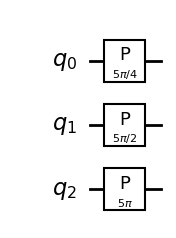

In [768]:
def plusN(n, result_qubits):
    
    # Creación del circuito.
    qc = QuantumCircuit(result_qubits, name=f"+{n}")
    
    for i in range(result_qubits):
        
        # Fórmula: Angulo Base * Valor
        angulo = (math.pi / (2 ** i)) * n
        
        # Aplicación de la rotación.
        qc.p(angulo, result_qubits - 1 - i) 
        
    return qc

plusN(5, 3).draw(output='mpl', style='bw')

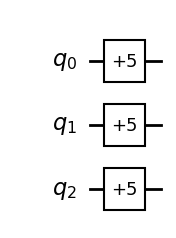

In [ ]:
def multiplication_result_qubits(qubits_in_operand):
    
    return 0

def multiplier(qubits_in_operand, value):
    
    result_qubits = multiplication_result_qubits(qubits_in_operand)
    
    quantum_circuit = QuantumCircuit(qubits_in_operand + result_qubits, name=f"x{value}")
    
    for i in range(qubits_in_operand, qubits_in_operand + result_qubits, 1):
        quantum_circuit.h(i)
        
    for i in range(qubits_in_operand):
        
        gate_columna = plusN(value, result_qubits)
        
        # La columna es controlada solo por un qubit.
        controlled_gate = gate_columna.to_gate().control(1)
        
        # Se definen los "cables": [Control, Objetivo1, Objetivo2, Objetivo3...].
        # Control: es el qubit 'i' (input).
        # Objetivos: son los qubits del acumulador (del 5 al 7).
        qubit_control = [i]
        qubits_objetivo = list(range(qubits_in_operand, qubits_in_operand + result_qubits))
        
        wiring = qubit_control + qubits_objetivo
        
        # Añadido del cableado al circuito.
        quantum_circuit.append(controlled_gate, wiring)
        
    # Se añade la transformada cuántica de Fourier inversa para decodificar el resultado.
    quantum_circuit.append(iqtf(result_qubits), list(range(qubits_in_operand, qubits_in_operand + result_qubits)))
        
    
    return quantum_circuit

constant = 5
number_of_qubits = 3
result_qubits = multiplication_result_qubits(number_of_qubits)
qc = multiplier(number_of_qubits, constant)
qc.draw(output='mpl', style='bw')